# Set up

In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LeakyReLU

# Function

In [2]:
def get_data():
    df=pd.read_csv('energydata_complete.csv')
    df['date'] = pd.to_datetime(df['date'])
    df= df.sort_values(['date'])
    df.set_index('date',inplace=True)
    df.drop(['rv1', 'rv2'],axis=1,inplace=True)
    return df

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def split_data(data):
    split_train =int(data.shape[0]*0.6)
    split_test = int(data.shape[0]*(0.6+0.2))
    
    train = data[:split_train]
    test = data[split_train:split_test]
    forecast = data[split_test:]
    
    return train,test,forecast

In [5]:
def get_xy(train,test,forecast):
    time_steps=1
    train_X, train_y = train.values[:, :-1], train.values[:, -1:]
    train_X=train_X.reshape((train_X.shape[0],time_steps, train_X.shape[1]))
    test_X, test_y = test.values[:, :-1], test.values[:, -1:]
    test_X=test_X.reshape((test_X.shape[0],time_steps, test_X.shape[1]))
    forecast_X,forecast_y = forecast.values[:, :-1], forecast.values[:, -1:]
    forecast_X=forecast_X.reshape((forecast_X.shape[0],time_steps, forecast_X.shape[1]))
    return train_X,train_y,test_X,test_y,forecast_X,forecast_y

In [6]:
def btscv(data,n_splits):
    class BlockingTimeSeriesSplit():
        def __init__(self, n_splits):
            self.n_splits = n_splits
    
        def get_n_splits(self, X, y, groups):
            return self.n_splits
    
        def split(self, X, y=None, groups=None):
            n_samples = len(X)
            k_fold_size = n_samples // self.n_splits
            indices = np.arange(n_samples)

            margin = 0
            for i in range(self.n_splits):
                start = i * k_fold_size
                stop = start + k_fold_size
                mid = int(0.8 * (stop - start)) + start
                yield indices[start: mid], indices[mid + margin: stop]
    btscv = BlockingTimeSeriesSplit(n_splits)
    train_count=[]
    test_count=[]
    i=0
    for train_val, test_val in btscv.split(train):
        train_count.append(len(train_val))
        test_count.append(len(test_val))
    train1, val1 = data[:train_count[0]], data[train_count[0]:int(train_count[0]+test_count[0])]
    train2, val2 = data[int(train_count[0]+test_count[0]):int(train_count[0]+test_count[0]+train_count[1])], data[int(train_count[0]+test_count[0]+train_count[1]):int(train_count[0]+test_count[0]+train_count[1]+test_count[1])]
    train3, val3 = data[int(train_count[0]+test_count[0]+train_count[1]+test_count[1]):int(train_count[0]+test_count[0]+train_count[1]+test_count[1]+train_count[2])], data[int(train_count[0]+test_count[0]+train_count[1]+test_count[1]+train_count[2]):int(train_count[0]+test_count[0]+train_count[1]+test_count[1]+train_count[2]+test_count[2])]

    return train1,train2,train3,val1,val2,val3

In [7]:
def split_to_predict(train1,train2,train3,val1,val2,val3):
    cv_train=[train1,train2,train3]
    cv_test=[val1,val2,val3]
    cv_xtrain=[]
    cv_ytrain=[]
    cv_xtest=[]
    cv_ytest=[]
    for i in range(3):
        train_X, train_y = cv_train[i].values[:, :-1], cv_train[i].values[:, -1:]
        cv_xtrain.append(train_X)
        cv_ytrain.append(train_y)
        test_X, test_y = cv_test[i].values[:, :-1], cv_test[i].values[:, -1:]
        cv_xtest.append(test_X)
        cv_ytest.append(test_y)   
    time_steps=1
    for i in range(3):
      cv_xtrain[i]=cv_xtrain[i].reshape((cv_xtrain[i].shape[0],time_steps, cv_xtrain[i].shape[1]))
      cv_xtest[i]=cv_xtest[i].reshape((cv_xtest[i].shape[0],time_steps, cv_xtest[i].shape[1]))
        
    return cv_xtrain,cv_ytrain,cv_xtest,cv_ytest

In [8]:
def loop_model(x_train,y_train,x_test,y_test):
    i=0
    for i in range(len(x_train)):
        model = Sequential()
        model.add(LSTM(32, activation='relu',return_sequences=True, input_shape=(x_train[i].shape[1],x_train[i].shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.summary()
        history = model.fit(x_train[i],y_train[i], epochs=200, batch_size=250, validation_data=(x_test[i],y_test[i]), verbose=1, shuffle=False)
        i=i+1
        if i == int(len(x_train)):
            break
    
    return model,history

In [9]:
def loss_plot(history):
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    

In [10]:
def inverse_scaled(x_test,y_test,yhat):
    x_test = x_test.reshape((x_test.shape[0],x_test.shape[2]))
    td=[]
    for i in range(26):
        ts=x_test[::,(i+1)]
        ts=ts.reshape(len(x_test),1)
        td.append(ts)
    inv_yhat=np.hstack((yhat,td[0],td[1],td[2],td[3],td[4],td[5],td[6],td[7],td[8],td[9],td[10],td[11],td[12],td[13],td[14],td[15],td[16],td[17],td[18],td[19],td[20],td[21],td[22],td[23],td[24]))
    inv_yhat = pd.DataFrame(inv_yhat,columns=df.columns)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat= inv_yhat[::,0] 
    inv_ytest=np.hstack((y_test,td[0],td[1],td[2],td[3],td[4],td[5],td[6],td[7],td[8],td[9],td[10],td[11],td[12],td[13],td[14],td[15],td[16],td[17],td[18],td[19],td[20],td[21],td[22],td[23],td[24]))
    inv_ytest = pd.DataFrame(inv_ytest,columns=df.columns)
    inv_ytest = scaler.inverse_transform(inv_ytest)
    inv_ytest = inv_ytest[::,0] 
    
    return inv_yhat,inv_ytest   

In [11]:
def error(y_test,y_hat):
    rmse = np.sqrt(mean_squared_error(y_test,y_hat))
    r2=r2_score(y_test,y_hat)

    return r2,rmse    

In [12]:
def plot_result(inv_yhat,inv_ytest,title):
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.plot(inv_yhat,color='r',label='prediction')
    plt.plot(inv_ytest,color='b',label='actual')
    plt.legend()
    plt.show()

In [13]:
def inverse_train(x_train,y_train):   
    x_train = x_train.reshape((x_train.shape[0],x_train.shape[2]))
    td=[]
    for i in range(26):
        ts=x_train[::,(i+1)]
        ts=ts.reshape(len(x_train),1)
        td.append(ts)
    inv_ytrain=np.hstack((y_train,td[0],td[1],td[2],td[3],td[4],td[5],td[6],td[7],td[8],td[9],td[10],td[11],td[12],td[13],td[14],td[15],td[16],td[17],td[18],td[19],td[20],td[21],td[22],td[23],td[24]))
    inv_ytrain = pd.DataFrame(inv_ytrain,columns=df.columns)
    inv_ytrain = scaler.inverse_transform(inv_ytrain)
    inv_ytrain= inv_ytrain[::,0] 
    
    return inv_ytrain

# Data preprocessing

In [14]:
df=get_data()
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_out=1
n_in=10
reframed = series_to_supervised(scaled, n_in, n_out,feat_name=df.columns)
reframed.drop(['lights(t)','T1(t)', 'RH_1(t)', 'T2(t)','RH_2(t)', 'T3(t)', 'RH_3(t)', 'T4(t)', 'RH_4(t)', 'T5(t)', 'RH_5(t)','T6(t)', 'RH_6(t)', 'T7(t)', 'RH_7(t)', 'T8(t)', 'RH_8(t)', 'T9(t)','RH_9(t)', 'T_out(t)', 'Press_mm_hg(t)', 'RH_out(t)', 'Windspeed(t)','Visibility(t)', 'Tdewpoint(t)'],axis=1,inplace=True)
train,test,forecast=split_data(reframed)
train1,train2,train3,val1,val2,val3=btscv(train,3)
cv_xtrain,cv_ytrain,cv_xtest,cv_ytest=split_to_predict(train1,train2,train3,val1,val2,val3)
train_X,train_y,test_X,test_y,forecast_X,forecast_y=get_xy(train,test,forecast)
x_train=[cv_xtrain[0],cv_xtrain[1],cv_xtrain[2],train_X]
y_train=[cv_ytrain[0],cv_ytrain[1],cv_ytrain[2],train_y]
x_test=[cv_xtest[0],cv_xtest[1],cv_xtest[2],test_X]
y_test=[cv_ytest[0],cv_ytest[1],cv_ytest[2],test_y]

# Train Model

In [15]:
model,history=loop_model(x_train,y_train,x_test,y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             37504     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 45,857
Trainable params: 45,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
13/13 [==============================] - 0s 26ms/step - loss: 0.0175 - val_loss: 0.0068
Epoch 2/200
13/13 

Epoch 73/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 74/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 75/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 76/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 77/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 78/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 79/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0046
Epoch 80/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 81/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 82/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0042


13/13 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 26/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 27/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 28/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0044
Epoch 29/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 30/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 31/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 32/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 33/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 34/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 35/200


Epoch 107/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 108/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 109/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 110/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 111/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 112/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 113/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 114/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 115/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 116/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0049 - val_los

13/13 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 189/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 190/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 191/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 192/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 193/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 194/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 195/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 196/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 197/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0033
Epoc

Epoch 60/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 61/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 62/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 63/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 64/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 65/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 66/200
13/13 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 67/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 68/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 69/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0029


48/48 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 13/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 14/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 15/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 16/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 17/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 18/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 19/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 20/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 21/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 22/200


48/48 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 95/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 96/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 97/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 98/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 99/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 100/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 101/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 102/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 103/200
48/48 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 104

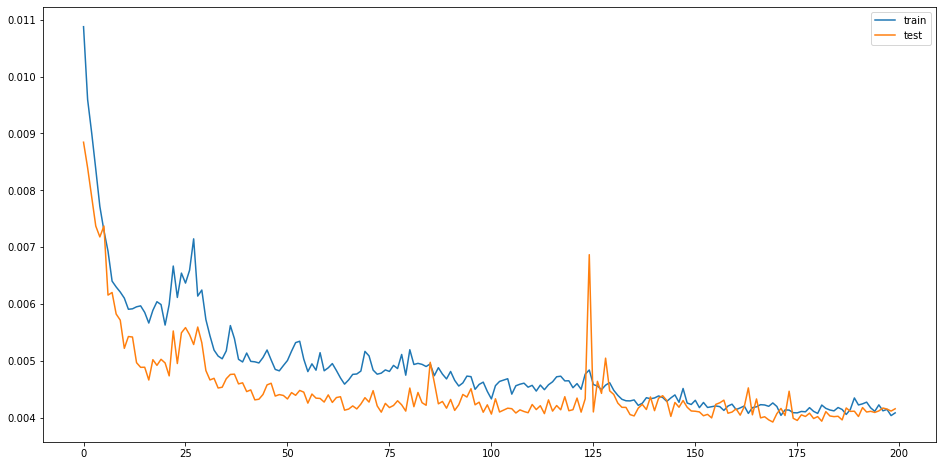

In [16]:
loss_plot(history)

In [17]:
yhat = model.predict(forecast_X) 

In [18]:
inv_yhat_forecast,inv_y_forecast=inverse_scaled(forecast_X,forecast_y,yhat)

In [19]:
r2f,rmsef=error(inv_y_forecast,inv_yhat_forecast)
print('Forecast RMSE Model1: %.3f' % rmsef)
print('Forecast R2-score Model1: %.3f' % r2f)

Forecast RMSE Model1: 65.631
Forecast R2-score Model1: 0.475


In [20]:
inv_ytrain=inverse_train(train_X,train_y)
inv_ytest=inverse_train(test_X,test_y)

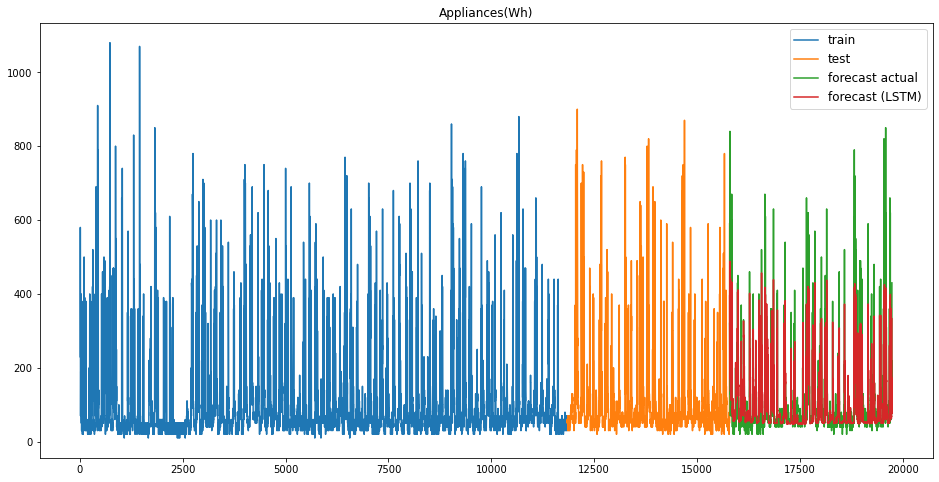

In [22]:
plt.figure(figsize=(16,8))
plt.title('Appliances(Wh)')
plt.plot(train.index,inv_ytrain,label='train')
plt.plot(test.index,inv_ytest,label='test')
plt.plot(forecast.index,inv_y_forecast,label='forecast actual')
plt.plot(forecast.index,inv_yhat_forecast,label='forecast (LSTM)')
plt.legend(fontsize = 'large')
plt.show()